<a href="https://colab.research.google.com/github/migueldelben/MBA/blob/main/MBA_DataScience_TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets
!pip install pytorch-metric-learning
!pip install faiss-gpu

## 1. Importando dados

In [ ]:
product_category = "Gift Cards"

In [ ]:
from datasets import Dataset, load_dataset, interleave_datasets

In [ ]:
!wget --no-check-certificate https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Gift_Cards.json.gz
!gzip -dkv Gift_Cards.json.gz

--2023-12-07 03:12:51--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Gift_Cards.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11333918 (11M) [application/x-gzip]
Saving to: ‘Gift_Cards.json.gz.1’

Gift_Cards.json.gz. 100%[===================>]  10.81M  39.1MB/s    in 0.3s    

2023-12-07 03:12:51 (39.1 MB/s) - ‘Gift_Cards.json.gz.1’ saved [11333918/11333918]

gzip: Gift_Cards.json already exists; do you wish to overwrite (y or n)? y
Gift_Cards.json.gz:	 77.1% -- created Gift_Cards.json


In [ ]:
import pandas as pd
df = pd.read_json("Gift_Cards.json", lines=True)

#The 'style' attribute has subattributes that are not consistent through all records, which result in a error when converting to a dataset.
df.drop(['style'],axis=1)

dataset = Dataset.from_pandas(df)
del df

In [ ]:
# creating 'label' column and removing unused columns
label = [1 if overall > 3 else 0 for overall in dataset["overall"]]
dataset = dataset.add_column(name="label", column=label)
dataset = dataset.remove_columns(['overall', 'verified', 'reviewerID', 'asin', 'style', 'reviewerName', 'summary', 'unixReviewTime', 'vote', 'image'])

In [ ]:
# checking if there are any ids for which 'reviewText' isn't a string
i = 0
exclude_ids = []
for item in dataset['reviewText']:
  if type(item) != str:
    exclude_ids.append(i)
  i += 1

# create new dataset exluding those ids
dataset = dataset.select(
    (
        i for i in range(len(dataset))
        if i not in set(exclude_ids)
    )
)

Parameter 'indices'=<generator object <genexpr> at 0x793ee7ec5310> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


### 1.1. Coluna 'reviewTime'
Para checar a presença de drift ao longo do tempo, é necessário dividir o conjunto de dados por ano. Para isso, fazemos uso da biblioteca **datetime**, para converter a coluna 'reviewTime' em um objeto de data que possibilite teste lógicos.



In [ ]:
from datetime import datetime, date

dates = []
for date in dataset['reviewTime']:
  dates.append(datetime.strptime(date, '%m %d, %Y').date())

dataset = dataset.add_column(name="date", column=dates)
dataset = dataset.remove_columns(['reviewTime'])

Flattening the indices:   0%|          | 0/147035 [00:00<?, ? examples/s]

In [ ]:
# separate each review considering its date, creating a separate dataset for each year
year = 1996
first_day = 1
first_month = 1
last_day = 31
last_month = 12

base_datasets = {}

while year <= 2018:
  base_datasets[str(year)] = dataset.filter(lambda x: x["date"] >= datetime(year, first_month, first_day).date() and x["date"] <= datetime(year, last_month, last_day).date())
  year += 1

Filter:   0%|          | 0/147035 [00:00<?, ? examples/s]

Filter:   0%|          | 0/147035 [00:00<?, ? examples/s]

Filter:   0%|          | 0/147035 [00:00<?, ? examples/s]

Filter:   0%|          | 0/147035 [00:00<?, ? examples/s]

Filter:   0%|          | 0/147035 [00:00<?, ? examples/s]

Filter:   0%|          | 0/147035 [00:00<?, ? examples/s]

Filter:   0%|          | 0/147035 [00:00<?, ? examples/s]

Filter:   0%|          | 0/147035 [00:00<?, ? examples/s]

Filter:   0%|          | 0/147035 [00:00<?, ? examples/s]

Filter:   0%|          | 0/147035 [00:00<?, ? examples/s]

Filter:   0%|          | 0/147035 [00:00<?, ? examples/s]

Filter:   0%|          | 0/147035 [00:00<?, ? examples/s]

Filter:   0%|          | 0/147035 [00:00<?, ? examples/s]

Filter:   0%|          | 0/147035 [00:00<?, ? examples/s]

Filter:   0%|          | 0/147035 [00:00<?, ? examples/s]

Filter:   0%|          | 0/147035 [00:00<?, ? examples/s]

Filter:   0%|          | 0/147035 [00:00<?, ? examples/s]

Filter:   0%|          | 0/147035 [00:00<?, ? examples/s]

Filter:   0%|          | 0/147035 [00:00<?, ? examples/s]

Filter:   0%|          | 0/147035 [00:00<?, ? examples/s]

Filter:   0%|          | 0/147035 [00:00<?, ? examples/s]

Filter:   0%|          | 0/147035 [00:00<?, ? examples/s]

Filter:   0%|          | 0/147035 [00:00<?, ? examples/s]

### 1.2. Distribuição por Ano

In [ ]:
# count how many reviews, in total, are in each year
reviews_amount = [len(base_datasets[year]['reviewText']) for year in base_datasets]
years = [int(year) for year in base_datasets]

In [ ]:
base_datasets

{'1996': Dataset({
     features: ['reviewText', 'label', 'date'],
     num_rows: 0
 }),
 '1997': Dataset({
     features: ['reviewText', 'label', 'date'],
     num_rows: 0
 }),
 '1998': Dataset({
     features: ['reviewText', 'label', 'date'],
     num_rows: 0
 }),
 '1999': Dataset({
     features: ['reviewText', 'label', 'date'],
     num_rows: 0
 }),
 '2000': Dataset({
     features: ['reviewText', 'label', 'date'],
     num_rows: 0
 }),
 '2001': Dataset({
     features: ['reviewText', 'label', 'date'],
     num_rows: 0
 }),
 '2002': Dataset({
     features: ['reviewText', 'label', 'date'],
     num_rows: 0
 }),
 '2003': Dataset({
     features: ['reviewText', 'label', 'date'],
     num_rows: 0
 }),
 '2004': Dataset({
     features: ['reviewText', 'label', 'date'],
     num_rows: 0
 }),
 '2005': Dataset({
     features: ['reviewText', 'label', 'date'],
     num_rows: 0
 }),
 '2006': Dataset({
     features: ['reviewText', 'label', 'date'],
     num_rows: 0
 }),
 '2007': Dataset({
  

In [ ]:
# checking label distribution of each year:
reviews_percentage_label_0 = []

for year in base_datasets:
  label_count_1, label_count_0 = 0, 0
  for label in base_datasets[year]['label']:
    if label == 1:
      label_count_1 += 1
    elif label == 0:
      label_count_0 += 1

  if(label_count_1 == 0 and label_count_0 == 0):
    reviews_percentage_label_0.append(0)
  else:
    percentage = (label_count_0/(label_count_1 + label_count_0)) * 100
    reviews_percentage_label_0.append(percentage)

#### 1.2.1. Gráfico de Número de Avaliações

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# create concataned dataset
df_reviews_amount = pd.DataFrame(data={'Classe': "Positiva + Negativa", 'year': years, 'Quantidade': reviews_amount})
df_reviews_percentage_label_0 = pd.DataFrame(data={'Classe': "Negativa", 'year': years, 'Quantidade': reviews_percentage_label_0})

reviews = pd.concat([df_reviews_amount, df_reviews_percentage_label_0], ignore_index=True)

# save dataset to csv file
reviews.to_csv('/content/drive/My Drive/MBA - IA e Data Science/TCC/Dados/Número de Avaliações (' + product_category + ').csv', index=False)

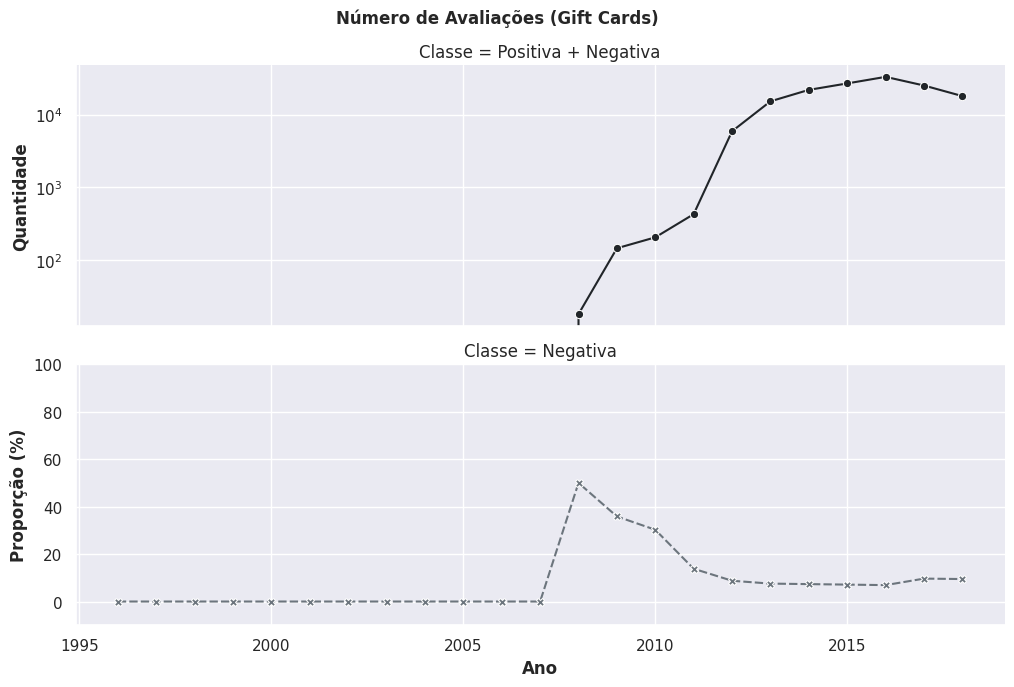

In [ ]:
# load dataset from csv file
reviews = pd.read_csv('/content/drive/My Drive/MBA - IA e Data Science/TCC/Dados/Número de Avaliações (' + product_category + ').csv')


# set sns theme
sns.set_theme()
sns.set_context("paper")
sns.set( rc={"figure.figsize":(15, 7)})

# plot
sns_plot = sns.relplot(reviews, x="year", y="Quantidade", row="Classe", kind='line', height = 3.5, aspect = 15/5, hue='Classe', palette=['#212529','#6C757D'], style='Classe', markers=True, legend=False, facet_kws=dict(sharey=False))

# title
sns_plot.fig.subplots_adjust(top=.9)
sns_plot.fig.suptitle("Número de Avaliações ("+ product_category +")", size=12, weight='bold')

# upper graph
sns_plot.axes[0,0].set_ylabel("Quantidade", fontdict={'weight': 'bold'})
sns_plot.axes[0,0].set_yscale('log')

# lower graph
sns_plot.axes[1,0].set_ylim(-10,100)
sns_plot.axes[1,0].set_ylabel("Proporção (%)", fontdict={'weight': 'bold'})
sns_plot.axes[1,0].set_xlabel("Ano", fontdict={'weight': 'bold'})

# save image
plt.savefig('/content/drive/My Drive/MBA - IA e Data Science/TCC/Imagens/PNG/Número de Avaliações (' + product_category + ').png')
plt.savefig('/content/drive/My Drive/MBA - IA e Data Science/TCC/Imagens/PDF/Número de Avaliações (' + product_category + ').pdf')
plt.show()


### 1.3. Splite Treino/Teste

In [ ]:
# define base year from which drift comparisons will be measured
base_year = '2010'
max_year = '2018'

# remove all datasets that are not between base_year and max_year
base_datasets_copy = base_datasets.copy()

for year in base_datasets_copy:
  if int(year) < int(base_year) or int(year) > int(max_year):
    del base_datasets[year]

In [ ]:
#enconding the classes of the dataset using 'label' and creating train/test splits
for year in base_datasets:
  base_datasets[year] = base_datasets[year].class_encode_column("label")
  base_datasets[year] = base_datasets[year].train_test_split(test_size=0.2, stratify_by_column="label")

#removing 'data' column because there are conversion problems of type numpy.datetime64 when training the model.
for year in base_datasets:
  base_datasets[year] = base_datasets[year].remove_columns(['date'])

Stringifying the column:   0%|          | 0/5193 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/5193 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/9554 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/9554 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/18371 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/18371 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/53152 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/53152 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/106781 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/106781 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/169659 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/169659 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/203481 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/203481 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/162364 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/162364 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/63452 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/63452 [00:00<?, ? examples/s]

In [ ]:
# create new training dataset with a greater number of data for which label = 0
#train_ds = interleave_datasets([ds['train'].filter(lambda x: x["label"] == 1), ds['train'].filter(lambda x: x["label"] == 0)], probabilities=[0.7,0.3], stopping_strategy="first_exhausted", seed=42)
#train_ds

## 2. Pré-processamento

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
import torch.nn as nn

In [ ]:
torch.manual_seed(0)

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(dataset):
  return tokenizer(dataset["reviewText"], truncation=True, padding=True)

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(dataset):
  return tokenizer(dataset["reviewText"], truncation=True, padding=True)

tokenized_datasets = {}

for year in base_datasets:
  tokenized_datasets[year] = base_datasets[year].map(preprocess_function, batched=True)

Map:   0%|          | 0/4154 [00:00<?, ? examples/s]

Map:   0%|          | 0/1039 [00:00<?, ? examples/s]

Map:   0%|          | 0/7643 [00:00<?, ? examples/s]

Map:   0%|          | 0/1911 [00:00<?, ? examples/s]

Map:   0%|          | 0/14696 [00:00<?, ? examples/s]

Map:   0%|          | 0/3675 [00:00<?, ? examples/s]

Map:   0%|          | 0/42521 [00:00<?, ? examples/s]

Map:   0%|          | 0/10631 [00:00<?, ? examples/s]

Map:   0%|          | 0/85424 [00:00<?, ? examples/s]

Map:   0%|          | 0/21357 [00:00<?, ? examples/s]

Map:   0%|          | 0/135727 [00:00<?, ? examples/s]

Map:   0%|          | 0/33932 [00:00<?, ? examples/s]

Map:   0%|          | 0/162784 [00:00<?, ? examples/s]

Map:   0%|          | 0/40697 [00:00<?, ? examples/s]

Map:   0%|          | 0/129891 [00:00<?, ? examples/s]

Map:   0%|          | 0/32473 [00:00<?, ? examples/s]

Map:   0%|          | 0/50761 [00:00<?, ? examples/s]

Map:   0%|          | 0/12691 [00:00<?, ? examples/s]

## 3. Modelo
Determinação dos parâmetros do modelo DistilBert. A única modificação é no número de parâmetros de saída para a aprendizado métrico.

In [ ]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]

'LABEL_1'

In [ ]:
#changing classifier layer for metric learning.
model.classifier = nn.Linear(768,128)
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

## 4. Treinamento

### 4.1. Preparações

In [ ]:
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from pytorch_metric_learning import losses, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [ ]:
### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
def train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch):
    model.train()
    for batch_idx, (ds_dict) in enumerate(train_loader):
        data, labels, mask = ds_dict["input_ids"].to(device), ds_dict["label"].to(device), ds_dict["attention_mask"].to(device)
        optimizer.zero_grad()
        loss_optimizer.zero_grad()
        embeddings = model(input_ids = data, attention_mask = mask)
        loss = loss_func(embeddings.logits, labels)
        loss.backward()
        optimizer.step()
        loss_optimizer.step()
        if batch_idx % 100 == 0:
            print("Epoch {} Iteration {}: Loss = {}".format(epoch, batch_idx, loss))

### 4.2. Treinamento

In [ ]:
torch.manual_seed(0)
device = torch.device("cuda")

batch_size = 4

ds_train = tokenized_datasets[base_year]["train"].with_format("torch")
train_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)

model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 2

In [ ]:
### pytorch-metric-learning stuff ###
loss_func = losses.SubCenterArcFaceLoss(num_classes=2, embedding_size=128).to(device)
loss_optimizer = torch.optim.Adam(loss_func.parameters(), lr=1e-4)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)
### pytorch-metric-learning stuff ###

In [ ]:
for epoch in range(1, num_epochs + 1):
    train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch)

Epoch 1 Iteration 0: Loss = 29.638614654541016
Epoch 1 Iteration 100: Loss = 30.113319396972656
Epoch 1 Iteration 200: Loss = 15.737052917480469
Epoch 1 Iteration 300: Loss = 30.608749389648438
Epoch 1 Iteration 400: Loss = 0.01678188517689705
Epoch 1 Iteration 500: Loss = 0.09933286905288696
Epoch 1 Iteration 600: Loss = 27.547788619995117
Epoch 1 Iteration 700: Loss = 0.07327361404895782
Epoch 1 Iteration 800: Loss = 0.061064302921295166
Epoch 1 Iteration 900: Loss = 14.63902473449707
Epoch 1 Iteration 1000: Loss = 14.611896514892578
Epoch 2 Iteration 0: Loss = 27.724517822265625
Epoch 2 Iteration 100: Loss = 0.02079092524945736
Epoch 2 Iteration 200: Loss = 0.32888492941856384
Epoch 2 Iteration 300: Loss = 13.790750503540039
Epoch 2 Iteration 400: Loss = 27.887590408325195
Epoch 2 Iteration 500: Loss = 0.017755094915628433
Epoch 2 Iteration 600: Loss = 0.4483940005302429
Epoch 2 Iteration 700: Loss = 0.5579655170440674
Epoch 2 Iteration 800: Loss = 14.05504322052002
Epoch 2 Iteratio

## 5. Medida de Drift
Para medir o drift ao longo dos anos, mediremos a distância entre os embeddings do dataset de treinamento considerando o ano base (2010) e os embeddings dos datasets de test dos demais anos.

In [ ]:
# getting train embeddings obtained considering year = 2010
base_embeddings = []

for batch_idx, (ds_dict) in enumerate(train_loader):
  data, labels, mask = ds_dict["input_ids"].to(device), ds_dict["label"].to(device), ds_dict["attention_mask"].to(device)
  embeddings = model(input_ids = data, attention_mask = mask)
  base_embeddings.append(embeddings.logits.detach().cpu().numpy()[0])
  #train_labels.append(labels.detach().cpu().item())

In [ ]:
test_loader = {}

for year in tokenized_datasets:
  ds_test = tokenized_datasets[year]["test"].with_format("torch")
  test_loader[year] = torch.utils.data.DataLoader(ds_test, batch_size=batch_size)

In [ ]:
test_embeddings = {}
embeddings = []

for year in test_loader:
  for batch_idx, (ds_dict) in enumerate(test_loader[year]):
    data, labels, mask = ds_dict["input_ids"].to(device), ds_dict["label"].to(device), ds_dict["attention_mask"].to(device)
    embedding = model(input_ids = data, attention_mask = mask)
    embeddings.append(embedding.logits.detach().cpu().numpy()[0])

  test_embeddings[year] = embeddings
  embeddings = []

In [ ]:
import numpy as np
np.random.seed(0)

In [ ]:
# calculating mean vector from embeddings for each year:
base_vector = np.mean(base_embeddings, axis=0)

test_vector = {}
for year in test_embeddings:
  test_vector[year] = np.mean(test_embeddings[year], axis=0)

### 5.1 Distância Euclidiana

In [ ]:
distances = []
years = []
for year in test_vector:
  distance = np.linalg.norm(base_vector - test_vector[year]) / np.linalg.norm(base_vector - test_vector[base_year])
  if np.isnan(distance):
    distances.append(0)
  else:
    distances.append(distance)

  years.append(int(year))

euc_distance = pd.DataFrame(data={'Distância': "Euclidiana", 'year': years, 'distance': distances})

### 5.2 Distância de Cosseno

In [ ]:
distances = []
years = []
norm = 1 - np.dot(test_vector[base_year], base_vector) / (np.linalg.norm(test_vector[base_year])*np.linalg.norm(base_vector))

for year in test_vector:
  distance = (1 - np.dot(test_vector[year], base_vector) / (np.linalg.norm(test_vector[year])*np.linalg.norm(base_vector))) / norm
  if isinstance(distance,np.ndarray):
    distances.append(0)
  else:
    distances.append(distance)

  years.append(int(year))

cos_distance = pd.DataFrame(data={'Distância': "Cosseno", 'year': years, 'distance': distances})

### 5.3 Gráfico de Distância por Ano

In [ ]:
# create concatenated dataset
distances = pd.concat([euc_distance, cos_distance], ignore_index=True)

# save dataset to csv file
distances.to_csv('/content/drive/My Drive/MBA - IA e Data Science/TCC/Dados/Medida de Drift (' + product_category + ').csv', index=False)

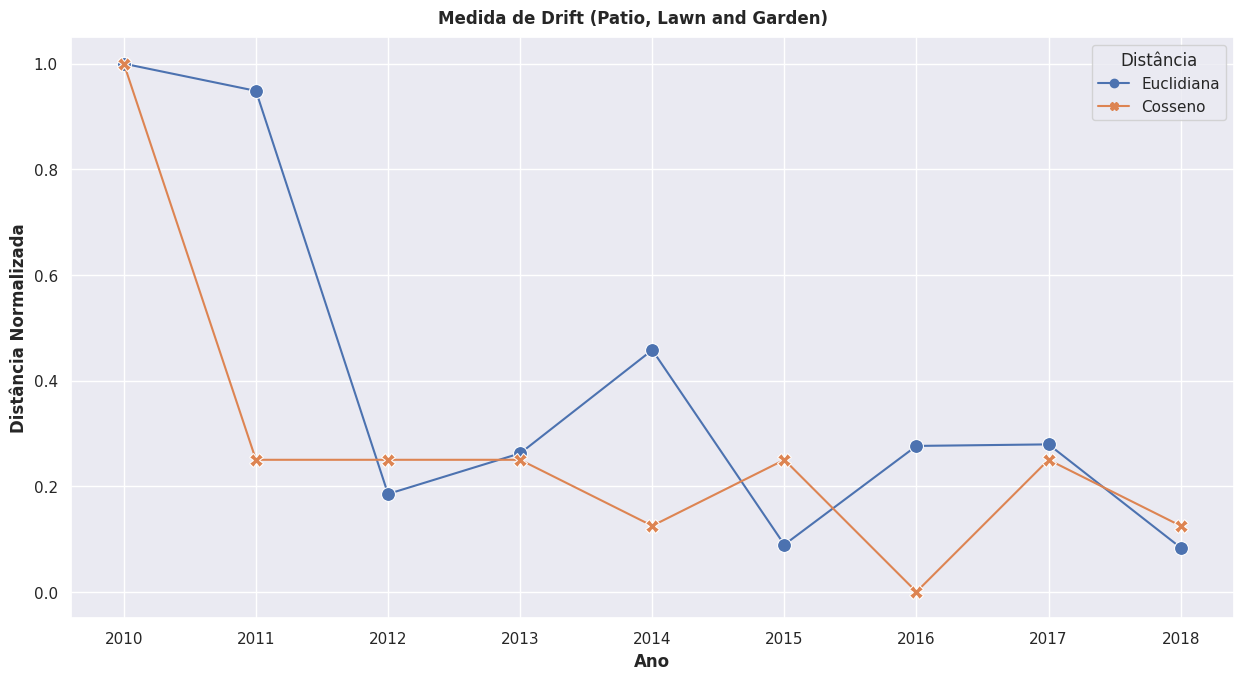

In [ ]:
# load dataset from csv file
distance = pd.read_csv('/content/drive/My Drive/MBA - IA e Data Science/TCC/Dados/Medida de Drift (' + product_category + ').csv')

# set sns theme
sns.set_theme()
sns.color_palette('muted')

sns.set_context("paper")
sns.set( rc={"figure.figsize":(15, 7)})

sns_plot = sns.lineplot(data=distance, x="year", y="distance", hue="Distância", style="Distância", markers=True, markersize=10, dashes=False)

# title
plt.subplots_adjust(top=.94)
plt.suptitle("Medida de Drift ("+ product_category +")", size=12, weight='bold')

# labels
sns_plot.set_xlabel('Ano',fontdict={'weight': 'bold'})
sns_plot.set_ylabel('Distância Normalizada',fontdict={'weight': 'bold'})

# save image
plt.savefig('/content/drive/My Drive/MBA - IA e Data Science/TCC/Imagens/PNG/Medida de Drift (' + product_category + ').png')
plt.savefig('/content/drive/My Drive/MBA - IA e Data Science/TCC/Imagens/PDF/Medida de Drift (' + product_category + ').pdf')
plt.show()

## Teste

In [ ]:
"""
 train_embeddings = []
 train_labels = []

 for batch_idx, (ds_dict) in enumerate(train_loader):
        data, labels, mask = ds_dict["input_ids"].to(device), ds_dict["label"].to(device), ds_dict["attention_mask"].to(device)
        embeddings = model(input_ids = data, attention_mask = mask)
        train_embeddings.append(embeddings.logits.detach().cpu().numpy()[0])
        train_labels.append(labels.detach().cpu().item())

 test_embeddings = []
 test_labels = []

 for batch_idx, (ds_dict) in enumerate(test_loader):
        data, labels, mask = ds_dict["input_ids"].to(device), ds_dict["label"].to(device), ds_dict["attention_mask"].to(device)
        embeddings = model(input_ids = data, attention_mask = mask)
        test_embeddings.append(embeddings.logits.detach().cpu().numpy()[0])
        test_labels.append(labels.detach().cpu().item())
"""

'\n train_embeddings = []\n train_labels = []\n\n for batch_idx, (ds_dict) in enumerate(train_loader):\n        data, labels, mask = ds_dict["input_ids"].to(device), ds_dict["label"].to(device), ds_dict["attention_mask"].to(device)\n        embeddings = model(input_ids = data, attention_mask = mask)\n        train_embeddings.append(embeddings.logits.detach().cpu().numpy()[0])\n        train_labels.append(labels.detach().cpu().item())\n\n test_embeddings = []\n test_labels = []\n\n for batch_idx, (ds_dict) in enumerate(test_loader):\n        data, labels, mask = ds_dict["input_ids"].to(device), ds_dict["label"].to(device), ds_dict["attention_mask"].to(device)\n        embeddings = model(input_ids = data, attention_mask = mask)\n        test_embeddings.append(embeddings.logits.detach().cpu().numpy()[0])\n        test_labels.append(labels.detach().cpu().item())\n'

In [ ]:
"""
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
import numpy as np

np.random.seed(0)
"""

'\nfrom sklearn.neighbors import KNeighborsClassifier\nfrom sklearn.metrics import accuracy_score\nimport sklearn.metrics as metrics\nimport numpy as np\n\nnp.random.seed(0)\n'

In [ ]:
"""
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(np.array(train_embeddings), np.array(train_labels))

pred_labels = knn.predict(test_embeddings)

accuracy_score(test_labels, pred_labels)
"""

'\nknn = KNeighborsClassifier(n_neighbors=5)\n\nknn.fit(np.array(train_embeddings), np.array(train_labels))\n\npred_labels = knn.predict(test_embeddings)\n\naccuracy_score(test_labels, pred_labels)\n'

In [ ]:
"""
print(metrics.confusion_matrix(test_labels,pred_labels))
print(metrics.classification_report(test_labels,pred_labels))
"""

'\nprint(metrics.confusion_matrix(test_labels,pred_labels))\nprint(metrics.classification_report(test_labels,pred_labels))\n'